In [1]:
# Initialize

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re,nltk,string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


In [3]:
raw_data = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")
df = raw_data.copy(deep=True)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


# 1. Import and Clean Data

In [4]:
def missing_data(df):
        total = df.isnull().sum().sort_values(ascending=False)
        percent_1 = df.isnull().sum()/df.isnull().count()*100
        percent_2 = (round(percent_1,1)).sort_values(ascending=False)
        percent_3 = df.count()
        missing_table = pd.concat([total,percent_2,percent_3],axis=1,keys=['Null','%','Count'])
        return(missing_table)
    
display(pd.concat([missing_data(df),pd.concat([df.dtypes,df.nunique()],axis = 1,keys = ['Type','Unique'])],axis = 1))

,Null,%,Count,Type,Unique
negativereason_gold,14608,99.8,32,object,13
airline_sentiment_gold,14600,99.7,40,object,3
tweet_coord,13621,93.0,1019,object,832
negativereason,5462,37.3,9178,object,10
user_timezone,4820,32.9,9820,object,85
tweet_location,4733,32.3,9907,object,3081
negativereason_confidence,4118,28.1,10522,float64,1410
tweet_id,0,0.0,14640,int64,14485
airline_sentiment,0,0.0,14640,object,3
airline_sentiment_confidence,0,0.0,14640,float64,1023


Luckily, missing values are not found in **airline_sentiment** and **text**. We can ignore the rest.

In [5]:
# Check duplicate rows

duplicateRows = df[df.duplicated()]
duplicateRows

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12040,570308309682675712,negative,1.0,Customer Service Issue,1.0,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito
12059,570305051819941889,neutral,1.0,NaN,NaN,American,NaN,Chandrafaythe,NaN,0,@AmericanAir my flight got Cancelled Flightled...,NaN,2015-02-24 11:31:34 -0800,NaN,Quito
12063,570303383782989824,neutral,1.0,NaN,NaN,American,NaN,trentgillaspie,NaN,0,.@AmericanAir just disappointed with the Fligh...,NaN,2015-02-24 11:24:57 -0800,"Austin, but often Denver",Mountain Time (US & Canada)
12066,570301929580048385,neutral,1.0,NaN,NaN,American,NaN,FinEdChat,NaN,0,@AmericanAir I did,NaN,2015-02-24 11:19:10 -0800,"Cincinnati, Ohio",Atlantic Time (Canada)
12068,570301395141836801,negative,1.0,Late Flight,1.0,American,NaN,JoBarredaV,NaN,1,@AmericanAir r u serious?? 304min #delay with ...,NaN,2015-02-24 11:17:02 -0800,Mexico City,Central Time (US & Canada)
12069,570300915418320897,negative,1.0,Cancelled Flight,1.0,American,NaN,LancasterPattie,NaN,0,@AmericanAir You are jumping the gun and Cance...,NaN,2015-02-24 11:15:08 -0800,NaN,NaN
12074,570299252141903873,positive,1.0,NaN,NaN,American,NaN,Mtts28,NaN,0,@AmericanAir This is exactly why ill be flying...,NaN,2015-02-24 11:08:32 -0800,Virginia,Eastern Time (US & Canada)
12075,570298770136674304,negative,1.0,Customer Service Issue,1.0,American,NaN,law_econ,NaN,0,@AmericanAir This doesn't address my issue. I ...,NaN,2015-02-24 11:06:37 -0800,"Newport Beach, CA",Central Time (US & Canada)
12078,570298644475346945,negative,1.0,Customer Service Issue,1.0,American,NaN,denismishin,NaN,0,@AmericanAir submitted a case to AA customer r...,NaN,2015-02-24 11:06:07 -0800,"Bellevue, WA",Eastern Time (US & Canada)
12079,570298371140939776,negative,1.0,Late Flight,1.0,American,NaN,djjohnpayne,NaN,0,@AmericanAir if by near the gate you mean sitt...,"[0.0, 0.0]",2015-02-24 11:05:01 -0800,"Las Vegas, NV",Pacific Time (US & Canada)


In [6]:
# Remove duplicated rows

df = df.drop_duplicates()
df[df.duplicated()]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


We create dataframe with necessary columns only.

In [7]:
df = df[['airline_sentiment', 'text']]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


Remove twitter usernames, numbers, punctuation and unusual whitespace

In [8]:
stemmer = PorterStemmer()
sw = stopwords.words('english')

def stem_tokens(tokens, stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return(stemmed)
def remove_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

def clean_text(text):
    # remove @username
    text = re.sub('@[^\s]+','',text)
    
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    
    text_nonum = remove_stopwords(text_nonum)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    

    return text_no_doublespace
df['text_cleaned'] = df['text'].apply(clean_text)
df.head()

,airline_sentiment,text,text_cleaned
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plus added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing


# 2. EDA

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

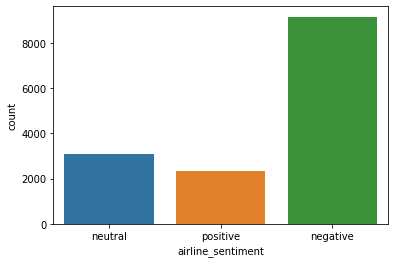

In [9]:
# Check the balance of data
sns.countplot(x = 'airline_sentiment',data = df)

List most common words for each target.

In [10]:
# top words

word_counts = {'positive': [],
                'neutral': [],
                'negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(df['text_cleaned'], df['airline_sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    word_counts[t].extend(text)

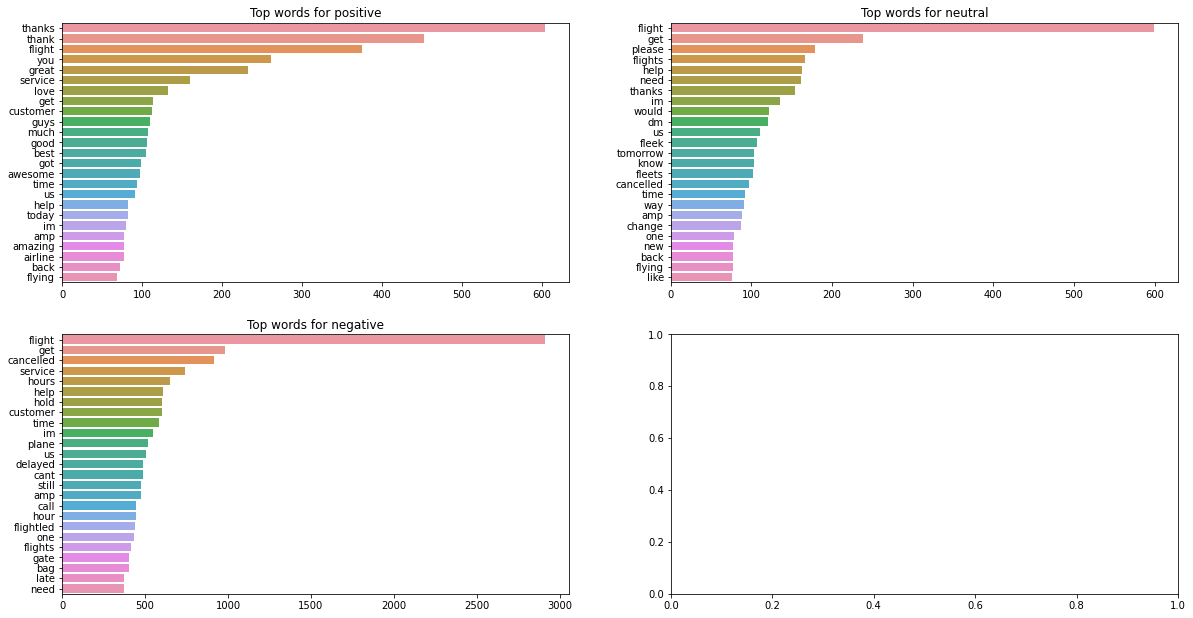

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

# 3. Data Preprocessing

In [12]:
# Data Preprocessing

# LabelEncoder feature into integers, 0, 1 2

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df.airline_sentiment.values)

# Check encoder mapping
lbl_name_mapping = dict(zip(lbl_enc.classes_, lbl_enc.transform(lbl_enc.classes_)))
lbl_name_mapping

{'negative': 0, 'neutral': 1, 'positive': 2}

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df.text_cleaned, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

# Define kfold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


print ('X_train = ', X_train.shape)
print ('X_test = ', X_test.shape)

X_train =  (13143,)
X_test =  (1461,)


In [14]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 3), stop_words = 'english', max_features=30000)

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_test))
X_train_ctv =  ctv.transform(X_train) 
X_test_ctv = ctv.transform(X_test)

print('(rows, features) = ', X_train_ctv.shape)
print('(rows, features) = ', X_test_ctv.shape)

(rows, features) =  (13143, 30000)
(rows, features) =  (1461, 30000)


# 4. Model
Choose the baseline models

In [15]:
models = [
         #Decision Tree:
         ('dt',DecisionTreeClassifier()),
    
         #Ensemble Methods:
         ('rfc',RandomForestClassifier(random_state=42)),

         #GLM: 
         ('lr',LogisticRegression(max_iter = 5000)),
    
         #SGD
         ('sgd', SGDClassifier()),             
                
         #xgboost:
         ('xgb',XGBClassifier())
]

In [16]:
# Define function to run models and compare their results


def compare_Model(models, X , y, cv, scoring, title):
    
    

    Model_columns = ['Model Name','Train Score('+title+')', 'Test Score('+title+')','std', 'Model Time']# ,'Model Parameters'
    Model_compare = pd.DataFrame(columns = Model_columns)


    row_index = 0
    for name,model  in models:
        
            Model_name = model.__class__.__name__
            cv_results = cross_validate(model,X,y,cv=cv,scoring=scoring,n_jobs=-1,return_train_score=True)

            Model_compare.loc[row_index,'Model Name'] = Model_name  # names.append(name)
            Model_compare.loc[row_index,'Model Time'] = cv_results['fit_time'].mean()
            Model_compare.loc[row_index,'Train Score('+title+')'] = cv_results['train_score'].mean()
            Model_compare.loc[row_index,'Test Score('+title+')'] = cv_results['test_score'].mean()

            Model_compare.loc[row_index,'std'] = cv_results['test_score'].std()

            row_index+=1

    Model_compare.sort_values(by = ['Test Score('+title+')'],ascending = False,inplace =True)
    return Model_compare

In [17]:
MLA_df = compare_Model(models, X_train_ctv , y_train, cv=kfold, scoring='f1_weighted', title='baseline')
MLA_df

,Model Name,Train Score(baseline),Test Score(baseline),std,Model Time
2,LogisticRegression,0.965553,0.775044,0.007198,3.338051
3,SGDClassifier,0.975794,0.762063,0.005248,0.134436
1,RandomForestClassifier,0.99185,0.745897,0.005393,62.160213
4,XGBClassifier,0.773225,0.709439,0.007728,12.522628
0,DecisionTreeClassifier,0.991844,0.692538,0.00883,5.330473


We will pick top 3 models

In [18]:
models = [
         ('lr',LogisticRegression(max_iter = 5000)),
         ('sgd', SGDClassifier()),
         ('xgb',XGBClassifier())
]

# 5. Improve accuracy
There various technique to improve the model performance, here are some examples:
1. Vectorize using TF-IDF
2. Configure ngram
4. Deal with the overfitting
3. Hyperparameter tuning

## 5.1. Vectorize using TF-IDF

In [19]:
# Try TF-IDF

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_test))
X_train_tfv =  tfv.transform(X_train) 
X_test_tfv = tfv.transform(X_test)

print('(row num, feature num) = ', X_train_tfv.shape)
print('(row num, feature num) = ', X_test_tfv.shape)

(row num, feature num) =  (13143, 8239)
(row num, feature num) =  (1461, 8239)


In [20]:
# Try TF-IDF

MLA_df_tfv = compare_Model(models, X_train_tfv , y_train, cv=kfold, scoring='f1_weighted', title='tfv')
MLA_df_tfv

,Model Name,Train Score(tfv),Test Score(tfv),std,Model Time
1,SGDClassifier,0.878608,0.752527,0.004442,0.087075
0,LogisticRegression,0.852977,0.747861,0.003802,1.288653
2,XGBClassifier,0.807796,0.708483,0.006655,19.988362


Compare CountVectorize and TfidfVectorizer

In [21]:
df_compare = pd.merge(left=MLA_df[['Model Name', 'Test Score(baseline)']], right=MLA_df_tfv[['Model Name', 'Test Score(tfv)']], how="left", on=["Model Name"])
df_compare

,Model Name,Test Score(baseline),Test Score(tfv)
0,LogisticRegression,0.775044,0.747861
1,SGDClassifier,0.762063,0.752527
2,RandomForestClassifier,0.745897,NaN
3,XGBClassifier,0.709439,0.708483
4,DecisionTreeClassifier,0.692538,NaN


Comparing to the CountVectorize, TfidfVectorizer falls behind in term of accuracy. However, its train score implies that this method is better for handling overfitting.

## 5.2. Configure ngram
Ngram makes the model cover long vocabulary, for example bigram and trigram. After reducing ngram range to 1 word, we filter out the redundant words.The models should be generalized and minimize the overfitting.

In [22]:
# Try TF-IDF

tfv_1word = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv_1word.fit(list(X_train) + list(X_test))
X_train_tfv_1word =  tfv_1word.transform(X_train) 
X_test_tfv_1word = tfv_1word.transform(X_test)

print('(row num, feature num) = ', X_train_tfv_1word.shape)
print('(row num, feature num) = ', X_test_tfv_1word.shape)

(row num, feature num) =  (13143, 3929)
(row num, feature num) =  (1461, 3929)


In [23]:
MLA_df_tfv_1word = compare_Model(models, X_train_tfv_1word , y_train, cv=kfold, scoring='f1_weighted', title='tfv_1word')
MLA_df_tfv_1word

,Model Name,Train Score(tfv_1word),Test Score(tfv_1word),std,Model Time
1,SGDClassifier,0.858321,0.755249,0.0061,0.077116
0,LogisticRegression,0.841891,0.753956,0.003584,0.971537
2,XGBClassifier,0.808349,0.710811,0.006449,16.316077


In [24]:
df_compare_2 = pd.merge(left=df_compare, right=MLA_df_tfv_1word[['Model Name', 'Test Score(tfv_1word)']], how="left", on=["Model Name"])
df_compare_2

,Model Name,Test Score(baseline),Test Score(tfv),Test Score(tfv_1word)
0,LogisticRegression,0.775044,0.747861,0.753956
1,SGDClassifier,0.762063,0.752527,0.755249
2,RandomForestClassifier,0.745897,NaN,NaN
3,XGBClassifier,0.709439,0.708483,0.710811
4,DecisionTreeClassifier,0.692538,NaN,NaN


## 5.3. Deal with the overfitting
One of the approach to minimize the overfitting is reducing the complexity or number of feature.

In [25]:
tfv_reduceFeature = TfidfVectorizer(min_df=3,  max_features=1000, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv_reduceFeature.fit(list(X_train) + list(X_test))
X_train_tfv_reduceFeature =  tfv_reduceFeature.transform(X_train) 
X_test_tfv_reduceFeature = tfv_reduceFeature.transform(X_test)

print('(row num, feature num) = ', X_train_tfv_reduceFeature.shape)
print('(row num, feature num) = ', X_test_tfv_reduceFeature.shape)

(row num, feature num) =  (13143, 1000)
(row num, feature num) =  (1461, 1000)


In [26]:
MLA_df_tfv_reduceFeature = compare_Model(models, X_train_tfv_reduceFeature , y_train, cv=kfold, scoring='f1_weighted', title='tfv_reduceFeature')
MLA_df_tfv_reduceFeature

,Model Name,Train Score(tfv_reduceFeature),Test Score(tfv_reduceFeature),std,Model Time
0,LogisticRegression,0.802855,0.752875,0.004193,0.761012
1,SGDClassifier,0.801757,0.752299,0.004535,0.068761
2,XGBClassifier,0.808577,0.714079,0.006969,13.457451


In [27]:
df_compare_3 = pd.merge(left=df_compare_2, right=MLA_df_tfv_reduceFeature[['Model Name', 'Test Score(tfv_reduceFeature)']], how="left", on=["Model Name"])
df_compare_3

,Model Name,Test Score(baseline),Test Score(tfv),Test Score(tfv_1word),Test Score(tfv_reduceFeature)
0,LogisticRegression,0.775044,0.747861,0.753956,0.752875
1,SGDClassifier,0.762063,0.752527,0.755249,0.752299
2,RandomForestClassifier,0.745897,NaN,NaN,NaN
3,XGBClassifier,0.709439,0.708483,0.710811,0.714079
4,DecisionTreeClassifier,0.692538,NaN,NaN,NaN


Not so good, the accuracy is lower. We will stick with the previous one.

## 5.4. Hyperparameter tuning

In [28]:
sgd_model = SGDClassifier(max_iter=10000)

param_grid_sgd = {
        "loss": ["hinge","log"],
        "alpha": [0.0001,0.00001],
        "penalty": ["l2","l1"],
}

sgd_grid = GridSearchCV(
        estimator=sgd_model,
        param_grid=param_grid_sgd,
        scoring ='f1_weighted',
        n_jobs =-1,
        cv =kfold,
        verbose=True
)
sgd_grid.fit(X_train_tfv_1word,y_train)

print(sgd_grid.best_score_)
print(sgd_grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.763893667731037
{'alpha': 1e-05, 'loss': 'log', 'penalty': 'l2'}


In [29]:
lgr_model = LogisticRegression(max_iter = 5000)

param_grid_lgr = {
        'C': [0.001,0.01,0.1,1,10,100]
}

lgr_grid = GridSearchCV(
        estimator=lgr_model,
        param_grid=param_grid_lgr,
        scoring ='f1_weighted',
        n_jobs =-1,
        cv =kfold,
        verbose=True
)
lgr_grid.fit(X_train_tfv_1word,y_train)

print(lgr_grid.best_score_)
print(lgr_grid.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.7565736976712697
{'C': 10}


In [30]:
xgb_model = XGBClassifier()

param_grid_xgb = {
        'max_depth':range(6,8,1),
        'n_estimators': [200,400],
        'learning_rate': [0.1,0.01,0.05]
}

xgb_grid = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid_xgb,
        scoring ='accuracy',
        n_jobs =-1,
        cv = kfold,
        verbose=True
)
xgb_grid.fit(X_train_tfv_1word,y_train)


print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7479269105336624
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}


In [31]:
# Define function to run models and compare their results
def compare_score(models, X_train , y_train, X_test, y_test):
    
    

    Model_columns = ['Model Name','Train Score', 'Test Score']# ,'Model Parameters'
    Model_compare = pd.DataFrame(columns = Model_columns)


    row_index = 0
    for name,model  in models:
        
            Model_name = model.__class__.__name__
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            score = accuracy_score(y_test, predictions)
            train_socre = model.score(X_train, y_train)
            
            Model_compare.loc[row_index,'Model Name'] = Model_name  # names.append(name)
            Model_compare.loc[row_index,'Train Score'] = train_socre
            Model_compare.loc[row_index,'Test Score'] = score


            row_index+=1

    Model_compare.sort_values(by = ['Test Score'],ascending = False,inplace =True)
    return Model_compare

In [32]:
# Apply hyperparameter from gridSearchCV

models_tuned = [
         ('lr',LogisticRegression(C=1, max_iter = 5000)),
         ('sgd', SGDClassifier(alpha = 1e-05, loss= 'log', penalty= 'l2')),
         ('xgb',XGBClassifier(learning_rate= 0.1, max_depth= 7, n_estimators= 400))
]

In [33]:
# Compare the accuracy of tuned model

valid_table  = compare_Model(models_tuned, X_train_tfv_1word , y_train, cv=kfold, scoring='f1_weighted', title='tuned')
valid_table

,Model Name,Train Score(tuned),Test Score(tuned),std,Model Time
1,SGDClassifier,0.910079,0.763035,0.007959,0.133344
0,LogisticRegression,0.841891,0.753956,0.003584,1.000801
2,XGBClassifier,0.854129,0.722014,0.007656,75.054133


SGDClassifier with tuned hyperparameter is the best performer here.

In [34]:
lgr = LogisticRegression(C=1, max_iter = 5000)
lgr.fit(X_train_tfv_1word, y_train)
y_pred = lgr.predict(X_test_tfv_1word)

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.80      0.93      0.86       916
     neutral       0.66      0.47      0.55       309
    positive       0.76      0.56      0.65       236

    accuracy                           0.77      1461
   macro avg       0.74      0.65      0.68      1461
weighted avg       0.76      0.77      0.76      1461



Although SGDClassifier gives the best test score, it suffer from the overfitting. If we look for the stable performance in long run LogisticRegression should be better option. Moreover the difference between test score of LogisticRegression and SGDClassifier is very small. </br>
LogisticRegression works very well on classifying **negative** tweets, however the accuracy of labeling **neutral** and **positive** tweets is pretty low. 
One reason could be the given dataset does not contain sufficient examples to train more accurate models.